<a href="https://colab.research.google.com/github/laribar/SmartAITraderBot/blob/main/Modelo_Funcional_Close%2C_Min_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil
from google.colab import files

# Caminho da pasta onde estão seus modelos
folder_path = '/content/models'

# Nome do arquivo zip que será criado
zip_filename = 'models_backup'

# Compactar toda a pasta /models em um arquivo .zip
shutil.make_archive(zip_filename, 'zip', folder_path)

print(f"✅ Pasta '{folder_path}' compactada como '{zip_filename}.zip'.")

# Fazer download do zip para seu computador
files.download(f'{zip_filename}.zip')


✅ Pasta '/content/models' compactada como 'models_backup.zip'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ========================================================
# 🚀 Instala ambiente correto para rodar o sistema
# ========================================================

# Instala pacotes principais (sem travar em versões antigas quebradas)
!pip install --upgrade --force-reinstall ta yfinance python-binance

# Corrige versões específicas necessárias
!pip install --upgrade --force-reinstall xgboost==2.0.3
!pip install --upgrade --force-reinstall numpy==1.26.4
!pip install --upgrade --force-reinstall scipy==1.12.0

# Mostra as versões instaladas para conferência
import xgboost
import numpy
import scipy
print("✅ Instalação concluída!")
print(f"xgboost version: {xgboost.__version__}")
print(f"numpy version: {numpy.__version__}")
print(f"scipy version: {scipy.__version__}")

# 🔄 (Opcional) Reinicia o runtime para carregar as libs novas:
import os
os.kill(os.getpid(), 9)



In [5]:
# ====================================================
# 1. IMPORTAÇÕES
# ====================================================
import yfinance as yf
import numpy as np
import pandas as pd
import ta
import requests
import time  # Para usar time.sleep()
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import pytz
import glob
import json
import warnings
import pandas as pd
import numpy as np
import os
import joblib
from xgboost import XGBClassifier, callback
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Fuso horário do Brasil
BR_TZ = pytz.timezone("America/Sao_Paulo")


# ====================================================
# BLOCO 1 - CONFIGURAÇÃO DE PASTAS E IMPORTS EXTRA
# ====================================================
import os
import joblib
from tensorflow.keras.models import load_model

# Criar pasta onde os modelos serão salvos
os.makedirs("/content/models", exist_ok=True)
# ====================================================
# BLOCO 2 - SALVAR E CARREGAR MODELOS TREINADOS
# ====================================================
def get_model_path(asset, interval, model_type="xgb"):
  asset_clean = asset.replace("-", "")
  ext = "joblib" if model_type == "xgb" else "h5"
  return f"/content/models/{model_type}_model_{asset_clean}_{interval}.{ext}"

# --- XGBoost ---
def save_xgb_model(model, asset, interval):
  path = get_model_path(asset, interval, model_type="xgb")
  joblib.dump(model, path)
  print(f"💾 Modelo XGBoost salvo em: {path}")

def load_xgb_model(asset, interval):
  path = get_model_path(asset, interval, model_type="xgb")
  if os.path.exists(path):
      print(f"📂 Modelo XGBoost carregado de: {path}")
      return joblib.load(path)
  return None

# --- LSTM ---
def save_lstm_model(model, asset, interval):
  path = get_model_path(asset, interval, model_type="lstm")
  model.save(path)
  print(f"💾 Modelo LSTM salvo em: {path}")

  # Salvar metadados no novo formato
  meta_path = path.replace(".h5", "_meta.pkl").replace(".keras", "_meta.pkl")
  joblib.dump({
      "scaler_x": model.scaler_x,
      "scaler_y": model.scaler_y,
      "feature_cols": model.feature_cols,
      "target_cols": model.target_cols,
      "window_size": model.window_size
  }, meta_path)
  print(f"📦 Metadados salvos em: {meta_path}")



def load_lstm_model(asset, interval, window_size=20):
  from tensorflow.keras.models import load_model
  import joblib
  import os

  model_path = get_model_path(asset, interval, model_type="lstm")
  meta_path = model_path.replace(".h5", "_meta.pkl").replace(".keras", "_meta.pkl")

  if not os.path.exists(model_path):
      print(f"🚫 Modelo LSTM NÃO encontrado em: {model_path}")
      return None

  try:
      model = load_model(model_path, compile=False)
      print(f"📂 Modelo LSTM encontrado em: {model_path}")
  except Exception as e:
      print(f"❌ Erro ao carregar modelo LSTM de {model_path}: {e}")
      return None

  # Carrega os metadados
  if os.path.exists(meta_path):
      try:
          meta = joblib.load(meta_path)
          model.scaler_x = meta.get("scaler_x")
          model.scaler_y = meta.get("scaler_y")
          model.feature_cols = meta.get("feature_cols")
          model.target_cols = meta.get("target_cols", ["High", "Low", "Close"])
          model.window_size = meta.get("window_size", window_size)

          # ✅ Compatibilidade com códigos antigos
          model.scaler = model.scaler_x

          print(f"📦 Metadados carregados de: {meta_path}")
      except Exception as e:
          print(f"⚠️ Erro ao carregar metadados de {meta_path}: {e}")
          model.scaler_x = None
          model.scaler_y = None
          model.scaler = None
          model.feature_cols = None
          model.target_cols = ["High", "Low", "Close"]
          model.window_size = window_size
  else:
      print(f"⚠️ Metadados não encontrados em: {meta_path}")
      model.scaler_x = None
      model.scaler_y = None
      model.scaler = None
      model.feature_cols = None
      model.target_cols = ["High", "Low", "Close"]
      model.window_size = window_size

  return model



# ====================================================
# 2. CONFIGURAÇÕES
# ====================================================
ASSETS = ["BTC-USD"]# , "ETH-USD", "SOL-USD", "XRP-USD", "AVAX-USD", "AAVE-USD", "DOT-USD", "NEAR-USD", "ADA-USD", "VIRTUAL-USD", "PENDLE-USD"]


TIMEFRAMES = [
  {"interval": "15m", "period": "30d", "atr": 0.02},
  {"interval": "1h", "period": "90d", "atr": 0.03},
  {"interval": "1d", "period": "1000d", "atr": 0.05},
  {"interval": "1wk", "period": "max", "atr": 0.08}  # 👈 Adicionado o semanal
]

TELEGRAM_TOKEN = "8142008777:AAHvP5uHzEmQqR4xKyu_bfm0Vf3C8cYbmj0"
TELEGRAM_CHAT_ID = "-4744645054"
ALERTA_VARIACAO_MINIMA = {
  "15m": 2.0,
  "1h": 4.0,
  "1d": 5.0,
  "1wk": 5.0
}
# ====================================================
# 3. COLETA DE DADOS
# ====================================================
def get_stock_data(asset, interval="15m", period="30d", max_retries=3, sleep_sec=5):
  import time
  for attempt in range(max_retries):
      try:
          data = yf.download(asset, period=period, interval=interval, progress=False, auto_adjust=False)
          if data.empty:
              raise ValueError(f"⚠️ Dados vazios recebidos de {asset} ({interval})")
          if isinstance(data.columns, pd.MultiIndex):
              data.columns = data.columns.get_level_values(0)
          data.columns = [col.split()[-1] if " " in col else col for col in data.columns]
          data = data.loc[:, ~data.columns.duplicated()]
          col_map = {col: std_col for col in data.columns for std_col in ["Open", "High", "Low", "Close", "Adj Close", "Volume"] if std_col.lower() in col.lower()}
          data = data.rename(columns=col_map)
          data = data[["Open", "High", "Low", "Close", "Volume"]]
          if not all(col in data.columns for col in ["Open", "High", "Low", "Close", "Volume"]):
              raise ValueError(f"⚠️ Colunas necessárias ausentes em {asset} ({interval})")
          return data
      except Exception as e:
          print(f"❌ Falha na tentativa {attempt+1} para {asset} ({interval}): {e}")
          time.sleep(sleep_sec)
  raise RuntimeError(f"❌ Falha ao baixar dados de {asset} ({interval}) após {max_retries} tentativas.")



def safe_read_csv(filepath):
  import os
  import pandas as pd

  if not os.path.exists(filepath):
      print(f"⚠️ Arquivo não encontrado: {filepath}")
      return None
  if os.path.getsize(filepath) == 0:
      print(f"⚠️ Arquivo está vazio: {filepath}")
      return None
  try:
      df = pd.read_csv(filepath)
      if df.empty or len(df.columns) == 0:
          print(f"⚠️ Arquivo inválido (sem colunas): {filepath}")
          return None
      return df
  except pd.errors.EmptyDataError:
      print(f"⚠️ Erro: arquivo sem colunas: {filepath}")
      return None
  except Exception as e:
      print(f"⚠️ Erro inesperado ao ler CSV: {e}")
      return None

def criar_prediction_log_padrao(filepath="/content/prediction_log.csv"):
  import pandas as pd
  import os

  colunas_padroes = [
      "Asset", "Timeframe", "Date", "Price", "Signal", "Confidence", "AdjustedProb",
      "TP1", "TP2", "SL", "Accuracy", "Precision", "Recall", "F1",
      "LSTM_Predicted", "TargetPrice",
      "LSTM_High_Predicted", "LSTM_Low_Predicted",  # ✅ Novas colunas
      "Acertou", "Resultado", "PrecoSaida", "LucroEstimado", "DuracaoMin"
  ]

  if not os.path.exists(filepath) or os.path.getsize(filepath) == 0:
      print(f"📄 Criando novo prediction_log com colunas padrão em: {filepath}")
      df_vazio = pd.DataFrame(columns=colunas_padroes)
      df_vazio.to_csv(filepath, index=False)
  else:
      try:
          df_existente = pd.read_csv(filepath)
          if df_existente.empty or len(df_existente.columns) == 0:
              print(f"⚠️ Arquivo está corrompido. Recriando...")
              df_vazio = pd.DataFrame(columns=colunas_padroes)
              df_vazio.to_csv(filepath, index=False)
          else:
              missing_cols = [col for col in colunas_padroes if col not in df_existente.columns]
              if missing_cols:
                  print(f"⚠️ Adicionando colunas faltantes: {missing_cols}")
                  for col in missing_cols:
                      df_existente[col] = None
                  df_existente.to_csv(filepath, index=False)
      except Exception as e:
          print(f"❌ Erro ao validar o log existente. Recriando. Erro: {e}")
          df_vazio = pd.DataFrame(columns=colunas_padroes)
          df_vazio.to_csv(filepath, index=False)





  # ====================================================
  # 4. INDICADORES TÉCNICOS
  # ====================================================
def calculate_indicators(data):
    data = data.copy().reset_index(drop=True)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        data[col] = data[col].astype(float)

    # Indicadores clássicos
    try:
        data["RSI"] = ta.momentum.RSIIndicator(close=data["Close"], window=14).rsi()
        data["SMA_50"] = ta.trend.SMAIndicator(close=data["Close"], window=50).sma_indicator()
        data["SMA_200"] = ta.trend.SMAIndicator(close=data["Close"], window=200).sma_indicator()

        macd = ta.trend.MACD(close=data["Close"])
        data["MACD"] = macd.macd()
        data["MACD_Signal"] = macd.macd_signal()

        bb = ta.volatility.BollingerBands(close=data["Close"], window=20)
        data["Bollinger_Upper"] = bb.bollinger_hband()
        data["Bollinger_Lower"] = bb.bollinger_lband()

        adx = ta.trend.ADXIndicator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
        data["ADX"] = adx.adx()

        stoch = ta.momentum.StochasticOscillator(high=data["High"], low=data["Low"], close=data["Close"], window=14)
        data["Stoch_K"] = stoch.stoch()
        data["Stoch_D"] = stoch.stoch_signal()

        # Indicadores adicionais
        data["ATR"] = ta.volatility.AverageTrueRange(high=data["High"], low=data["Low"], close=data["Close"]).average_true_range()
        data["ROC"] = ta.momentum.ROCIndicator(close=data["Close"], window=12).roc()
        data["OBV"] = ta.volume.OnBalanceVolumeIndicator(close=data["Close"], volume=data["Volume"]).on_balance_volume()
        data["CCI"] = ta.trend.CCIIndicator(high=data["High"], low=data["Low"], close=data["Close"], window=20).cci()

        ichimoku = ta.trend.IchimokuIndicator(high=data["High"], low=data["Low"], window1=9, window2=26)
        data["Tenkan_Sen"] = ichimoku.ichimoku_conversion_line()
        data["Kijun_Sen"] = ichimoku.ichimoku_base_line()

    except Exception as e:
        print(f"⚠️ Erro ao calcular indicadores: {e}")

    # VWAP
    try:
        data["TP"] = (data["High"] + data["Low"] + data["Close"]) / 3
        data["VWAP"] = (data["TP"] * data["Volume"]).cumsum() / (data["Volume"].replace(0, np.nan).cumsum())
        data.drop("TP", axis=1, inplace=True)
    except Exception as e:
        print(f"⚠️ Erro ao calcular VWAP: {e}")

    # Candlestick patterns
    try:
        data["Doji"] = ((abs(data["Close"] - data["Open"]) / (data["High"] - data["Low"] + 1e-9)) < 0.1).astype(int)
        data["Engulfing"] = ((data["Open"].shift(1) > data["Close"].shift(1)) & (data["Open"] < data["Close"]) &
                            (data["Close"] > data["Open"].shift(1)) & (data["Open"] < data["Close"].shift(1))).astype(int)
        data["Hammer"] = (((data["High"] - data["Low"]) > 3 * abs(data["Open"] - data["Close"])) &
                        ((data["Close"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6) &
                        ((data["Open"] - data["Low"]) / (data["High"] - data["Low"] + 1e-9) > 0.6)).astype(int)
    except Exception as e:
        print(f"⚠️ Erro ao calcular padrões de candle: {e}")
        # Garante que existam
        data["Doji"] = 0
        data["Engulfing"] = 0
        data["Hammer"] = 0

    data.dropna(inplace=True)
    return data




# ====================================================
# 4. MODELOS DE MACHINE LEARNING (XGBoost + LSTM)
# ====================================================

def get_feature_columns(df, include_lstm_pred=False):
    """
    Retorna a lista de colunas de features para os modelos.
    Se include_lstm_pred=True, inclui a coluna LSTM_PRED para uso no XGBoost.
    """
    base_features = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'SMA_5', 'SMA_20', 'EMA_12', 'EMA_26',
        'RSI', 'MACD', 'MACD_signal', 'MACD_hist',
        'BB_upper', 'BB_middle', 'BB_lower',
        'ATR', 'CCI', 'ROC', 'OBV'
    ]
    if include_lstm_pred:
        base_features.append("LSTM_PRED")
    return [col for col in base_features if col in df.columns]


def get_lstm_feature_columns():
    return [
        "Close", "High", "Low",  # 🟢 Agora inclui as três colunas principais como features também
        "RSI", "MACD", "MACD_Signal", "SMA_50", "SMA_200",
        "Bollinger_Upper", "Bollinger_Lower",
        "ADX", "Stoch_K", "Stoch_D",
        "ATR", "ROC", "OBV", "CCI",
        "Tenkan_Sen", "Kijun_Sen", "VWAP",
        "Doji", "Engulfing", "Hammer"
    ]


def prepare_lstm_data(data, feature_cols=None, target_cols=["High", "Low", "Close"], window_size=20):
    if feature_cols is None:
        feature_cols = get_lstm_feature_columns()

    missing = [col for col in feature_cols + target_cols if col not in data.columns]
    if missing:
        raise ValueError(f"❌ Colunas ausentes no DataFrame: {missing}")

    df = data[feature_cols + target_cols].dropna().astype(float)
    if len(df) < window_size + 1:
        raise ValueError(f"⚠️ Dados insuficientes: {len(df)} rows, necessário mínimo {window_size + 1}")

    # Escalonamento separado
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_X = scaler_x.fit_transform(df[feature_cols])
    scaled_y = scaler_y.fit_transform(df[target_cols])

    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(scaled_X[i - window_size:i])
        y.append(scaled_y[i])  # Previsão para o instante i

    X = np.array(X)
    y = np.array(y)

    print(f"✅ prepare_lstm_data | X.shape: {X.shape}, y.shape: {y.shape}")
    return X, y, scaler_x, scaler_y



def train_lstm_model(df, *, asset, interval, window_size=20, force_retrain=False):
    import os
    import numpy as np
    import joblib
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import MinMaxScaler

    feature_cols = get_lstm_feature_columns()
    target_cols = ["High", "Low", "Close"]
    df = df.dropna(subset=feature_cols + target_cols)

    if len(df) <= window_size:
        raise ValueError("Dados insuficientes para treino do LSTM.")

    df_features = df[feature_cols]
    df_targets = df[target_cols]

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_features = scaler_x.fit_transform(df_features)
    scaled_targets = scaler_y.fit_transform(df_targets)

    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(scaled_features[i - window_size:i])
        y.append(scaled_targets[i])

    X = np.array(X)
    y = np.array(y)

    print(f"✅ X.shape: {X.shape}, y.shape: {y.shape}")

    model_path = get_model_path(asset, interval, model_type="lstm")
    meta_path = model_path.replace(".h5", "_meta.pkl")

    if not force_retrain and os.path.exists(model_path):
        model = load_lstm_model(asset, interval)
        if model and all(hasattr(model, attr) for attr in ["scaler_x", "scaler_y", "feature_cols", "window_size", "target_cols"]):
            return model
        else:
            print("⚠️ Modelo existente não contém atributos. Será refeito.")

    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(3))  # Prever [High, Low, Close]
    model.compile(optimizer='adam', loss='mse')

    es = EarlyStopping(patience=10, restore_best_weights=True)
    model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[es], verbose=0)

    # Atributos para reuso
    model.scaler_x = scaler_x
    model.scaler_y = scaler_y
    model.scaler = scaler_x  # ✅ Compatibilidade com códigos antigos
    model.feature_cols = feature_cols
    model.target_cols = target_cols
    model.window_size = window_size

    model.save(model_path)
    joblib.dump({
        "scaler_x": scaler_x,
        "scaler_y": scaler_y,
        "feature_cols": feature_cols,
        "target_cols": target_cols,
        "window_size": window_size
    }, meta_path)

    print(f"💾 Modelo LSTM salvo em: {model_path}")
    print(f"📦 Metadados salvos em: {meta_path}")
    return model


import pandas as pd
import numpy as np
import os
import joblib
from xgboost import XGBClassifier, callback
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report


def train_ml_model(data, asset=None, interval=None, verbose=False):
    from xgboost import callback

    if asset and interval:
        existing_model = load_xgb_model(asset, interval)
        if existing_model is not None:
            print(f"✅ Modelo XGBoost já existente para {asset} ({interval}), carregado.")
            return existing_model

    if len(data) < 100:
        return None

    df = data.copy()
    df = calculate_indicators(df)

    try:
        lstm_model = train_lstm_model(df, asset=asset, interval=interval, window_size=20, force_retrain=False)

        if lstm_model:
            print("✅ Features usadas no LSTM:")
            print(lstm_model.feature_cols)

            print("✅ Últimos dados de entrada:")
            print(df[lstm_model.feature_cols].tail(3))

            print("✅ Valores mínimos do scaler X:")
            print(lstm_model.scaler_x.data_min_)
            print("✅ Valores máximos do scaler X:")
            print(lstm_model.scaler_x.data_max_)

        if lstm_model is not None:
            lstm_preds = []
            for i in range(len(df)):
                sub_df = df.iloc[:i+1]
                if len(sub_df) < lstm_model.window_size:
                    lstm_preds.append(np.nan)
                else:
                    try:
                        pred = predict_with_lstm(lstm_model, sub_df)
                        lstm_preds.append(pred.get("Close", np.nan))
                    except Exception as e:
                        print(f"⚠️ Erro ao prever com LSTM: {e}")
                        lstm_preds.append(np.nan)
            df["LSTM_PRED"] = lstm_preds
        else:
            df["LSTM_PRED"] = np.nan

    except Exception as e:
        print(f"⚠️ Erro ao gerar LSTM_PRED: {e}")
        df["LSTM_PRED"] = np.nan

    if "LSTM_PRED" not in df.columns:
        print("❌ Coluna 'LSTM_PRED' não foi gerada. Abortando treino do XGBoost.")
        return None

    df["Future_Close"] = df["Close"].shift(-5)
    df["Future_Return"] = df["Future_Close"] / df["Close"] - 1
    df = df[(df["Future_Return"] > 0.015) | (df["Future_Return"] < -0.015)].copy()
    df["Signal"] = np.where(df["Future_Return"] > 0.015, 1, 0)

    features = get_feature_columns(df, include_lstm_pred=True)
    df.dropna(inplace=True)

    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        print(f"❌ Features ausentes: {missing_features}")
        return None

    X = df[features]
    y = df["Signal"]

    if len(np.unique(y)) < 2:
        return None

    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        break

    if len(np.unique(y_train)) < 2:
        return None

    scale_pos_weight = len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))

    model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale_pos_weight,
        random_state=42
    )

    # ✅ CORREÇÃO: early_stopping_rounds no lugar de callbacks

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=10,
        verbose=False
    )



    y_pred = model.predict(X_val)
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)

    model.validation_score = {
        "accuracy": report.get("accuracy"),
        "precision": report.get("1", {}).get("precision"),
        "recall": report.get("1", {}).get("recall"),
        "f1": report.get("1", {}).get("f1-score")
    }

    if verbose:
        print(f"✅ Validação: {model.validation_score}")

    if asset and interval:
        save_xgb_model(model, asset, interval)

    return model





def predict_with_lstm(model, df, asset="N/A", interval="N/A"):
    """
    Faz a previsão com LSTM usando o último window de dados.
    Inclui validações para evitar valores irreais e registra previsões descartadas.
    """

    if not all(hasattr(model, attr) for attr in ['scaler_x', 'scaler_y', 'feature_cols', 'window_size']):
        raise AttributeError("O modelo LSTM não possui os atributos necessários (scaler_x, scaler_y, feature_cols, window_size).")

    df = df.copy().dropna(subset=model.feature_cols)
    if len(df) < model.window_size:
        raise ValueError("Dados insuficientes para previsão com LSTM.")

    last_window = df[model.feature_cols].values[-model.window_size:]
    scaled_window = model.scaler_x.transform(last_window)
    X_input = np.expand_dims(scaled_window, axis=0)

    pred_scaled = model.predict(X_input, verbose=0)[0].reshape(1, -1)
    pred_descaled = model.scaler_y.inverse_transform(pred_scaled)[0]

    high, low, close = float(pred_descaled[0]), float(pred_descaled[1]), float(pred_descaled[2])

    # 🔒 Correção 1: High deve ser maior ou igual ao Low
    if low > high:
        print(f"⚠️ Corrigindo inversão de High/Low na previsão LSTM. High={high:.2f}, Low={low:.2f}")
        high, low = max(high, low), min(high, low)

    # 🔒 Correção 2: Close deve ficar entre Low e High
    if close < low or close > high:
        print(f"⚠️ Ajustando Close fora da faixa. Antes: {close:.2f}")
        close = max(min(close, high), low)
        print(f"✅ Close ajustado para: {close:.2f}")

    # 🔒 Validação 3: Verifica se o Close projetado é plausível (não explodiu)
    preco_atual = df["Close"].iloc[-1]
    if preco_atual > 0:
        variacao_permitida = 0.5  # 50%
        if abs(close - preco_atual) / preco_atual > variacao_permitida:
            print(f"❌ Previsão absurda detectada. Atual={preco_atual:.2f} Previsto={close:.2f}")
            log_previsao_absurda(asset=asset, interval=interval, preco_atual=preco_atual, close_previsto=close)
            return {"High": None, "Low": None, "Close": None}

    return {
        "High": round(high, 4),
        "Low": round(low, 4),
        "Close": round(close, 4)
    }





def plot_feature_importance(model, feature_names, top_n=15):
    """
    Plota a importância das features do modelo XGBoost.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print("❌ O modelo não possui 'feature_importances_'.")
        return

    indices = np.argsort(importances)[-top_n:][::-1]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features[::-1], top_importances[::-1])
    plt.xlabel('Importância')
    plt.title('Top Features Importantes')
    plt.tight_layout()
    plt.show()



  # ====================================================
  # 5. UTILITÁRIOS
  # ====================================================
  # ====================================================
  # FUNÇÃO GLOBAL DE CONVERSÃO ESCALAR
  # ====================================================
def to_scalar(val):
    try:
        if isinstance(val, pd.Series):
            return float(val.iloc[0])
        elif isinstance(val, (np.ndarray, list)):
            return float(val[0])
        elif pd.isna(val):
            return np.nan
        else:
            return float(val)
    except Exception as e:
        print(f"❌ Falha ao converter valor escalar: {val} | erro: {e}")
        return np.nan

import os
import glob

def limpar_model_results():
    arquivos = glob.glob("/content/model_results_*.csv")
    if not arquivos:
        print("📂 Nenhum arquivo model_results_*.csv encontrado.")
        return

def plot_entrada_lstm(df, feature_cols):
    import matplotlib.pyplot as plt
    df_plot = df[feature_cols].tail(100).copy()
    df_plot.plot(figsize=(12, 5), title="📊 Últimas 100 entradas das features LSTM")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def gerar_resumo_ultimos_sinais(asset, interval, n=15, path="/content/prediction_log.csv"):
    df_log = safe_read_csv(path)
    if df_log is None or df_log.empty:
        return "📭 Sem sinais anteriores registrados."

    df_log = df_log[(df_log["Asset"] == asset) & (df_log["Timeframe"] == interval)].copy()
    df_log["Date"] = pd.to_datetime(df_log["Date"], utc=True).dt.tz_convert(BR_TZ)
    df_log = df_log.sort_values("Date", ascending=False).head(n)

    linhas = []
    for _, row in df_log.iterrows():
        data_str = row["Date"].strftime("%d/%m %H:%M")
        sinal = "COMPRA" if row["Signal"] == 1 else "VENDA" if row["Signal"] == 0 else "NEUTRO"
        emoji = "✔️" if row.get("Resultado") == "TP1" else "❌" if row.get("Resultado") == "SL" else "➖"
        lucro = row.get("LucroEstimado", "")
        lucro_str = f" | Lucro: {lucro:+.2f}" if pd.notna(lucro) else ""
        linhas.append(f"{emoji} {sinal} | {row['Asset']} | {data_str}{lucro_str}")

    # Acurácia dos últimos sinais (apenas TP1 e SL considerados)
    df_valid = df_log[df_log["Resultado"].isin(["TP1", "SL"])]
    if not df_valid.empty:
        acertos = (df_valid["Resultado"] == "TP1").sum()
        total = len(df_valid)
        acuracia = round(100 * acertos / total, 2)
        linhas.append(f"\n📈 <b>Acurácia:</b> {acuracia}% ({acertos}/{total})")

    return "📊 <b>Últimos Sinais:</b>\n" + "\n".join(linhas)


def gerar_ranking_lucro(path="/content/prediction_log.csv", top_n=5):
    df = safe_read_csv(path)
    if df is None or df.empty or "LucroEstimado" not in df.columns:
        return "📭 Sem dados de lucro disponíveis."

    df = df.dropna(subset=["Asset", "LucroEstimado"])
    df = df[df["Resultado"].isin(["TP1", "SL", "Sem alvo"])]
    df_grouped = df.groupby("Asset")["LucroEstimado"].sum().sort_values(ascending=False).head(top_n)

    linhas = ["🏆 <b>Top Ativos por Lucro Total:</b>"]
    for ativo, lucro in df_grouped.items():
        emoji = "🟢" if lucro > 0 else "🔴" if lucro < 0 else "⚪"
        linhas.append(f"{emoji} {ativo}: ${lucro:+.2f}")
    return "\n".join(linhas)

def gerar_resumo_por_padrao(asset, interval, path="/content/prediction_log.csv"):
    df = safe_read_csv(path)
    if df is None or df.empty:
        return "📭 Sem sinais anteriores registrados."

    df = df[(df["Asset"] == asset) & (df["Timeframe"] == interval)]
    subset_cols = ["Doji", "Engulfing", "Hammer"]
    subset_cols = [col for col in subset_cols if col in df.columns]
    if subset_cols:
        df = df.dropna(subset=subset_cols)

    df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.tz_convert(BR_TZ)

    ultimos = df.sort_values("Date", ascending=False).head(50)

    contagem = {
        "Doji": ultimos["Doji"].sum() if "Doji" in ultimos.columns else 0,
        "Engolfo": ultimos["Engulfing"].sum() if "Engulfing" in ultimos.columns else 0,
        "Martelo": ultimos["Hammer"].sum() if "Hammer" in ultimos.columns else 0
    }


    linhas = ["🔎 <b>Padrões Recentes Detectados:</b>"]
    for nome, qtd in contagem.items():
        if qtd > 0:
            linhas.append(f"• {nome}: {int(qtd)} ocorrência(s)")
    return "\n".join(linhas) if len(linhas) > 1 else "⚪ Nenhum padrão técnico detectado recentemente."

def generate_explanation(row, prediction, feature_importance=None):
    """
    Gera explicação técnica com base em indicadores e no sinal previsto (compra/venda).
    """
    try:
        explicacao = []

        if prediction == 1:
            explicacao.append("🟢 O modelo prevê uma tendência de ALTA (compra).")
        elif prediction == 0:
            explicacao.append("🔴 O modelo prevê uma tendência de BAIXA (venda).")
        else:
            explicacao.append("⚪ Tendência neutra — sem sinal claro.")

        # Indicadores clássicos
        if "RSI" in row:
            if row["RSI"] < 30:
                explicacao.append("• RSI indica sobrevenda (RSI < 30).")
            elif row["RSI"] > 70:
                explicacao.append("• RSI indica sobrecompra (RSI > 70).")

        if "MACD" in row and "MACD_Signal" in row:
            if row["MACD"] > row["MACD_Signal"]:
                explicacao.append("• MACD cruzando para cima da linha de sinal (potencial alta).")
            else:
                explicacao.append("• MACD abaixo da linha de sinal (potencial queda).")

        if "SMA_50" in row and "SMA_200" in row:
            if row["SMA_50"] > row["SMA_200"]:
                explicacao.append("• SMA 50 acima da 200 (tendência de alta no médio prazo).")
            else:
                explicacao.append("• SMA 50 abaixo da 200 (tendência de baixa no médio prazo).")

        if "ADX" in row and row["ADX"] > 20:
            explicacao.append("• ADX > 20 (tendência direcional presente).")

        # Padrões de candle
        if row.get("Doji") == 1:
            explicacao.append("• Padrão Doji detectado (possível reversão).")
        if row.get("Engulfing") == 1:
            explicacao.append("• Padrão de engolfo detectado (reversão possível).")
        if row.get("Hammer") == 1:
            explicacao.append("• Padrão de martelo identificado (alta possível).")

        # Importância de features (se disponível)
        if feature_importance:
            explicacao.append("\n📊 Principais influências do modelo:")
            top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:3]
            for name, weight in top_features:
                explicacao.append(f"• {name}: peso {weight:.3f}")

        return "\n".join(explicacao)

    except Exception as e:
        return f"⚠️ Erro ao gerar explicação: {str(e)}"

def enviar_grafico_previsao_futura(df_previsao, timeframe, asset):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import os
    import pandas as pd

    if df_previsao is None or not all(k in df_previsao for k in ["Date", "High", "Low", "Close"]):
        print(f"⚠️ Dados de previsão futura incompletos para {asset} ({timeframe})")
        return

    df = pd.DataFrame(df_previsao)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=False)

    plt.figure(figsize=(10, 4))

    for i in range(len(df)):
        date = df["Date"].iloc[i]
        high = df["High"].iloc[i]
        low = df["Low"].iloc[i]
        close = df["Close"].iloc[i]

        plt.vlines(date, ymin=low, ymax=high, color="blue", linewidth=2, label="Projeção" if i == 0 else "")
        plt.plot(date, close, marker="o", color="blue")

        # Rótulo com valor previsto
        plt.annotate(f"{close:.0f}", (date, close), xytext=(0, 8),
                     textcoords="offset points", ha='center', fontsize=8, color="blue")

    plt.title(f"🔮 Projeção Futura (LSTM) — {asset} ({timeframe})")
    plt.xlabel("Data")
    plt.ylabel("Preço Projetado")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M', tz=BR_TZ))
    plt.xticks(rotation=45)

    image_path = f"/tmp/projecao_futura_{asset.replace('-', '')}_{timeframe}.png"
    plt.savefig(image_path)
    plt.close()
    print(f"✅ Gráfico de projeção futura salvo: {image_path}")

    # Enviar para Telegram
    if os.path.exists(image_path):
        with open(image_path, "rb") as img:
            url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
            files = {"photo": img}
            data = {
                "chat_id": TELEGRAM_CHAT_ID,
                "caption": f"🔮 Projeção Futura — {asset} ({timeframe})"
            }
            response = requests.post(url, data=data, files=files)
            if response.status_code == 200:
                print("✅ Gráfico de projeção futura enviado ao Telegram.")
            else:
                print(f"❌ Erro ao enviar gráfico: {response.status_code} - {response.text}")


def calculate_targets(price_row, signal, atr_multiplier=0.02):
    """
    Calcula TP e SL com base em Low como entrada e High como alvo.
    Usa atr_multiplier para margem no SL.
    Retorna Entry, TP1, TP2, SL com validação contra valores inválidos.
    """
    if signal == 1:  # Compra
        entry = price_row.get("Low", None)
        tp1 = price_row.get("High", None)
        sl = entry - (entry * atr_multiplier) if entry is not None else None
    elif signal == 0:  # Venda
        entry = price_row.get("High", None)
        tp1 = price_row.get("Low", None)
        sl = entry + (entry * atr_multiplier) if entry is not None else None
    else:
        return {"Entry": None, "TP1": None, "TP2": None, "SL": None}

    # Proteção contra valores ausentes ou inválidos
    if any(v is None or np.isnan(v) for v in [entry, tp1, sl]):
        print("⚠️ Targets inválidos detectados — retornando None.")
        return {"Entry": None, "TP1": None, "TP2": None, "SL": None}

    # Cálculo de TP2 baseado na distância entre Entry e SL
    distancia = abs(entry - sl)
    tp2 = entry + 2 * distancia if signal == 1 else entry - 2 * distancia

    return {
        "Entry": round(entry, 4),
        "TP1": round(tp1, 4),
        "TP2": round(tp2, 4),
        "SL": round(sl, 4)
    }



def log_previsao_absurda(asset, interval, preco_atual, close_previsto):
    try:
        path = "/content/previsoes_descartadas.csv"
        row = {
            "Data": datetime.now(BR_TZ).strftime("%Y-%m-%d %H:%M:%S"),
            "Asset": asset,
            "Timeframe": interval,
            "PrecoAtual": preco_atual,
            "PrevistoClose": close_previsto,
            "Variacao(%)": round((close_previsto - preco_atual) / preco_atual * 100, 2)
        }
        df = pd.DataFrame([row])
        if os.path.exists(path):
            df.to_csv(path, mode="a", header=False, index=False)
        else:
            df.to_csv(path, index=False)
        print(f"🧾 Previsão absurda registrada em: {path}")
    except Exception as e:
        print(f"⚠️ Falha ao logar previsão absurda: {e}")




def send_telegram_message(message):
    url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage"
    payload = {"chat_id": TELEGRAM_CHAT_ID, "text": message, "parse_mode": "HTML"}
    response = requests.post(url, json=payload)

    if response.status_code == 200:
        print("📨 Mensagem enviada com sucesso!")
    else:
        print(f"❌ Erro ao enviar mensagem: {response.status_code} - {response.text}")

def predict_next_closes(data, n_steps=5):
    df = data.copy().reset_index(drop=True)
    features = get_feature_columns(df)
    df.dropna(inplace=True)

    X = df[features]
    y = df["Close"].shift(-1).dropna()
    X = X.loc[y.index]

    if len(X) < 100:
        return [None] * n_steps

    model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
    model.fit(X, y)

    last_row = df[features].iloc[-1].copy()
    preds = []

    for step in range(n_steps):
        X_input = pd.DataFrame([last_row], columns=features)
        next_close = model.predict(X_input)[0]
        preds.append(round(next_close, 2))

        # Simula avanço do mercado
        last_row["Close"] = next_close
        if "SMA_50" in last_row:
            last_row["SMA_50"] = last_row["SMA_50"] * 0.9 + next_close * 0.1
        if "SMA_200" in last_row:
            last_row["SMA_200"] = last_row["SMA_200"] * 0.95 + next_close * 0.05
        if "VWAP" in last_row:
            last_row["VWAP"] = last_row["VWAP"] * 0.95 + next_close * 0.05
        if "RSI" in last_row:
            last_row["RSI"] = min(100, max(0, last_row["RSI"] + np.random.normal(0, 0.5)))
        if "MACD" in last_row:
            last_row["MACD"] += np.random.normal(0, 0.3)
        if "MACD_Signal" in last_row:
            last_row["MACD_Signal"] += np.random.normal(0, 0.2)

        last_row = last_row[features]

    return preds


def evaluate_past_predictions(results_file="/content/prediction_log.csv", lookahead_candles=5):
    import os
    import pandas as pd
    import yfinance as yf
    import matplotlib.pyplot as plt
    from datetime import timedelta

    df = safe_read_csv(results_file)
    if df is None or df.empty:
        print("📭 Nenhum log de previsão encontrado ou o arquivo está vazio.")
        return

    df["Date"] = pd.to_datetime(df["Date"])
    print(f"📊 Avaliando {len(df)} previsões salvas...")

    evaluation = []


    for idx, row in df.iterrows():
        asset = row["Asset"]
        interval = row["Timeframe"]
        prediction_time = row["Date"]
        predicted_signal = row["Signal"]
        predicted_target = row.get("TargetPrice", None)

        try:
            candles = yf.download(asset, start=prediction_time, interval=interval, progress=False)
            candles = candles[candles.index > prediction_time]

            if candles.empty or len(candles) < lookahead_candles:
                continue

            candles = candles.head(lookahead_candles)
            final_close = candles["Close"].iloc[-1]

            if predicted_signal == 1:
                result = "Acertou" if final_close >= predicted_target else "Errou"
            elif predicted_signal == 0:
                result = "Acertou" if final_close <= predicted_target else "Errou"
            else:
                result = "Neutro"

            if predicted_target:
                perc_change = ((final_close - predicted_target) / predicted_target) * 100
                abs_error = final_close - predicted_target
            else:
                perc_change = None
                abs_error = None

            acertou = 1 if result == "Acertou" else 0

            evaluation.append({
                "Ativo": asset,
                "Timeframe": interval,
                "Data Previsão": prediction_time.strftime("%Y-%m-%d %H:%M"),
                "Sinal Previsto": "Compra" if predicted_signal == 1 else "Venda" if predicted_signal == 0 else "Neutro",
                "Valor Projetado (LSTM)": round(predicted_target, 2) if predicted_target else None,
                "Resultado": result,
                "Valor Real": round(final_close, 2),
                "Variação Real": f"{perc_change:+.2f}%" if perc_change is not None else "N/A",
                "Erro Absoluto": f"{abs_error:+.2f}" if abs_error is not None else "N/A",
                "Acertou": acertou
            })

        except Exception as e:
            print(f"⚠️ Erro ao avaliar {asset} em {prediction_time}: {e}")
            continue

    df_eval = pd.DataFrame(evaluation)

    # 📊 Resumo de acertos e erros
    resumo = df_eval.groupby(["Ativo", "Timeframe", "Resultado"]).size().unstack(fill_value=0)
    resumo["Total"] = resumo.sum(axis=1)
    resumo["Acurácia (%)"] = (resumo.get("Acertou", 0) / resumo["Total"] * 100).round(2)
    display(resumo)

    # 📈 Gráfico de barras
    resumo_plot = resumo[["Acertou", "Errou"]] if "Errou" in resumo.columns else resumo[["Acertou"]]
    resumo_plot.plot(kind="bar", figsize=(10, 5), title="📊 Acertos vs Erros por Ativo e Timeframe")
    plt.ylabel("Quantidade de Sinais")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()

    # 📄 Tabela completa das previsões
    display(df_eval)

    # 🔄 Atualizar o prediction_log.csv com a coluna 'Acertou'
    try:
        df_log = safe_read_csv(results_file)
        df_log["Date"] = pd.to_datetime(df_log["Date"], utc=True).dt.tz_convert(BR_TZ)


        for _, row in df_eval.iterrows():
            dt = pd.to_datetime(row["Data Previsão"])
            mask = (df_log["Date"] == dt) & (df_log["Asset"] == row["Ativo"]) & (df_log["Timeframe"] == row["Timeframe"])
            df_log.loc[mask, "Acertou"] = row["Acertou"]

        df_log.to_csv(results_file, index=False)
        print("✅ Log de previsões atualizado com coluna 'Acertou'.")

    except Exception as e:
        print(f"❌ Erro ao atualizar o prediction_log.csv com 'Acertou': {e}")

    return df_eval





def clear_models(model_dir="/content/models"):
    import shutil

    if os.path.exists(model_dir):
        print(f"🧹 Limpando todos os modelos salvos em: {model_dir}")
        shutil.rmtree(model_dir)
        os.makedirs(model_dir, exist_ok=True)
        print("✅ Modelos deletados com sucesso.")
    else:
        print("📂 Nenhuma pasta de modelos encontrada para limpar.")



def plot_prediction_performance_por_timeframe(log_path="/content/prediction_log.csv"):
    if not os.path.exists(log_path):
        print("📭 Nenhum log encontrado.")
        return

    df = pd.read_csv(log_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.dropna(subset=["TargetPrice", "Price", "Timeframe"])

    for timeframe in df["Timeframe"].unique():
        df_tf = df[df["Timeframe"] == timeframe].copy()
        df_tf["Erro"] = df_tf["Price"] - df_tf["TargetPrice"]
        df_tf["AbsError"] = abs(df_tf["Erro"])
        df_tf["Dia"] = df_tf["Date"].dt.date

        if df_tf.empty:
            continue

        # Erro absoluto médio por dia
        plt.figure(figsize=(8, 4))
        df_grouped = df_tf.groupby("Dia")["AbsError"].mean()
        plt.plot(df_grouped.index, df_grouped.values, marker="o")
        plt.title(f"📈 Erro Absoluto Médio por Dia - {timeframe}")
        plt.xlabel("Data")
        plt.ylabel("Erro ($)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"/tmp/erro_absoluto_{timeframe}.png")
        plt.close()

        # Dispersão do valor previsto x real
        plt.figure(figsize=(8, 4))
        plt.scatter(df_tf["TargetPrice"], df_tf["Price"], alpha=0.6)
        plt.plot([df_tf["TargetPrice"].min(), df_tf["TargetPrice"].max()],
                [df_tf["TargetPrice"].min(), df_tf["TargetPrice"].max()], 'r--', label="Perfeito")
        plt.title(f"🎯 Previsão LSTM vs Preço Real - {timeframe}")
        plt.xlabel("Valor Previsto")
        plt.ylabel("Valor Real")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        path_img = f"/tmp/previsao_vs_real_{timeframe}.png"
        plt.savefig(path_img)
        plt.close()
        print(f"✅ Gráfico salvo: {path_img}")

def enviar_graficos_desempenho_por_timeframe():
    import glob
    from pathlib import Path

    timeframes = ["15m", "1h", "1d"]  # Edite se tiver outros
    path_base = "/tmp"

    for tf in timeframes:
        # Gráfico 1: Previsão vs Real
        grafico_pred = f"{path_base}/previsao_vs_real_{tf}.png"
        if os.path.exists(grafico_pred):
            with open(grafico_pred, "rb") as img:
                url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
                files = {"photo": img}
                data = {
                    "chat_id": TELEGRAM_CHAT_ID,
                    "caption": f"📈 Previsão LSTM vs Real — {tf}"
                }
                r = requests.post(url, data=data, files=files)
                print(f"✅ Enviado: previsao_vs_real_{tf}.png")

        # Gráfico 2: Erro absoluto por dia
        grafico_erro = f"{path_base}/erro_absoluto_{tf}.png"
        if os.path.exists(grafico_erro):
            with open(grafico_erro, "rb") as img:
                url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
                files = {"photo": img}
                data = {
                    "chat_id": TELEGRAM_CHAT_ID,
                    "caption": f"📊 Erro Absoluto por Dia — {tf}"
                }
                r = requests.post(url, data=data, files=files)
                print(f"✅ Enviado: erro_absoluto_{tf}.png")

def enviar_grafico_lucro_por_confianca(log_path="/content/prediction_log.csv"):
    import matplotlib.pyplot as plt

    if not os.path.exists(log_path):
        print("📭 Nenhum log encontrado.")
        return

    df = safe_read_csv(log_path)
    if "AdjustedProb" not in df.columns or "TP1" not in df.columns or "Price" not in df.columns:
        print("⚠️ Colunas necessárias não encontradas no log.")
        return

    df = df.dropna(subset=["AdjustedProb", "TP1", "Price"])
    df["LucroEstimado"] = df["TP1"] - df["Price"]
    df["FaixaConfiança"] = pd.cut(df["AdjustedProb"], bins=[0, 0.6, 0.7, 0.8, 0.9, 1.0], labels=["≤60%", "60-70%", "70-80%", "80-90%", ">90%"])

    lucro_medio = df.groupby("FaixaConfiança")["LucroEstimado"].mean()

    plt.figure(figsize=(8, 4))
    lucro_medio.plot(kind="bar", color="skyblue")
    plt.title("📊 Lucro Estimado Médio por Faixa de Confiança")
    plt.ylabel("Lucro Estimado ($)")
    plt.xlabel("Faixa de Confiança Ajustada")
    plt.grid(True)
    plt.tight_layout()

    path = "/tmp/lucro_por_confianca.png"
    plt.savefig(path)
    plt.close()

    with open(path, "rb") as img:
        url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
        files = {"photo": img}
        data = {
            "chat_id": TELEGRAM_CHAT_ID,
            "caption": "📊 Lucro médio estimado por faixa de confiança ajustada"
        }
        response = requests.post(url, data=data, files=files)
        if response.status_code == 200:
            print("✅ Gráfico de lucro por confiança enviado.")
        else:
            print(f"❌ Falha ao enviar gráfico: {response.status_code} - {response.text}")

def adjust_signal_based_on_history(asset, timeframe, max_lookback=20, min_signals=5):
    try:
        df = safe_read_csv("prediction_log.csv")
        if df is None:
            print("⚠️ Ignorando leitura do prediction_log.csv pois está vazio ou ausente.")
            return 1.0  # Retorna confiança padrão

        df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.tz_convert(BR_TZ)

        df = df[(df["Asset"] == asset) & (df["Timeframe"] == timeframe)]

        if len(df) < min_signals or "Acertou" not in df.columns:
            return 1.0

        recent = df.sort_values("Date", ascending=False).head(max_lookback)
        acuracia = recent["Acertou"].mean()
        return acuracia

    except Exception as e:
        print(f"⚠️ Erro ao ajustar com histórico: {e}")
        return 1.0

def gerar_grafico_previsao_vs_real(log_path="/content/prediction_log.csv", output_path="/tmp/previsao_vs_real.png"):
    import matplotlib.pyplot as plt

    df = safe_read_csv(log_path)
    if df is None or df.empty or "TargetPrice" not in df.columns or "Price" not in df.columns:
        print("⚠️ Log inválido ou colunas ausentes.")
        return None

    df = df.dropna(subset=["TargetPrice", "Price"]).tail(20)  # últimos 20 sinais
    df["Date"] = pd.to_datetime(df["Date"])

    plt.figure(figsize=(10, 4))
    plt.plot(df["Date"], df["Price"], label="📈 Preço Real", marker="o")
    plt.plot(df["Date"], df["TargetPrice"], label="🔮 Previsão LSTM", marker="x")
    plt.title("📊 Previsão LSTM vs Preço Real")
    plt.xlabel("Data")
    plt.ylabel("Preço")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    print(f"✅ Gráfico salvo em: {output_path}")
    return output_path

def enviar_grafico_previsao_real(df, timeframe, asset):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import os

    df = df[df["Asset"] == asset].copy()
    if df.empty:
        print(f"⚠️ Nenhum dado para {asset} ({timeframe}) no gráfico.")
        return

    df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.tz_convert(BR_TZ)

    plt.figure(figsize=(12, 5))

    for i in range(len(df)):
        date = df["Date"].iloc[i]
        high = df["LSTM_High_Predicted"].iloc[i]
        low = df["LSTM_Low_Predicted"].iloc[i]
        close = df["TargetPrice"].iloc[i]
        real = df["Price"].iloc[i]

        cor = "green" if close >= real else "red"
        plt.vlines(date, ymin=low, ymax=high, color=cor, linewidth=2)
        plt.plot(date, close, marker="o", color=cor)

        # Rótulos numéricos
        plt.annotate(f"{close:.0f}", (date, close), xytext=(0, 8),
                    textcoords="offset points", ha='center', fontsize=8, color=cor)
        plt.annotate(f"{real:.0f}", (date, real), xytext=(0, -12),
                    textcoords="offset points", ha='center', fontsize=8, color="black")

    # Linha contínua do preço real
    plt.plot(df["Date"], df["Price"], label="📈 Preço Real", marker="x", color="black")

    plt.title(f"📊 Projeção LSTM (High/Low/Close) — {asset} ({timeframe})")
    plt.xlabel("Data")
    plt.ylabel("Preço")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M', tz=BR_TZ))
    plt.xticks(rotation=45)

    image_path = f"/tmp/previsao_vs_real_{asset.replace('-', '')}_{timeframe}.png"
    plt.savefig(image_path)
    plt.close()

    # Enviar para Telegram
    if os.path.exists(image_path):
        with open(image_path, "rb") as img:
            url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
            files = {"photo": img}
            data = {
                "chat_id": TELEGRAM_CHAT_ID,
                "caption": f"📊 Projeção LSTM (High/Low/Close) — {asset} ({timeframe})"
            }
            response = requests.post(url, data=data, files=files)
            if response.status_code == 200:
                print("✅ Gráfico de candle com rótulos enviado ao Telegram.")
            else:
                print(f"❌ Erro ao enviar gráfico: {response.status_code} - {response.text}")










def enviar_grafico_carteira():
    image_path = "/tmp/evolucao_carteira.png"
    if os.path.exists(image_path):
        with open(image_path, "rb") as img:
            url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendPhoto"
            files = {"photo": img}
            data = {
                "chat_id": TELEGRAM_CHAT_ID,
                "caption": "💼 Evolução da carteira virtual com base nos sinais do bot"
            }
            response = requests.post(url, data=data, files=files)
            if response.status_code == 200:
                print("✅ Gráfico da carteira enviado ao Telegram.")
            else:
                print(f"❌ Erro ao enviar imagem: {response.status_code} - {response.text}")

# 📊 Cálculo automático do atr_multiplier baseado nos últimos candles
def calcular_atr_auto(dataframe, intervalo="15m", n=50, fator_ajuste=1.2):
    try:
        df_recent = dataframe.tail(n)
        if df_recent.empty or not all(col in df_recent.columns for col in ["High", "Low", "Close"]):
            return 0.03  # valor padrão caso não tenha dados

        # Cálculo da média da variação percentual entre High e Low
        media_range_pct = ((df_recent["High"] - df_recent["Low"]) / df_recent["Close"]).mean()
        atr_multiplier = round(media_range_pct * fator_ajuste, 4)

        # Valor mínimo e máximo para manter limites razoáveis
        atr_multiplier = max(0.01, min(atr_multiplier, 0.08))
        return atr_multiplier

    except Exception as e:
        print(f"⚠️ Erro no ajuste automático do ATR: {e}")
        return 0.03  # fallback padrão


  # ====================================================
  # 5.1 CARTEIRA VIRTUAL PARA SIMULAÇÃO
  # ====================================================
  # ====================================================
  # 5.1 CARTEIRA VIRTUAL PARA SIMULAÇÃO
  # ====================================================

carteira_virtual = {
    "capital_inicial": 10000.0,
    "capital_atual": 10000.0,
    "capital_maximo": 10000.0,  # para cálculo de drawdown
    "historico_capital": [],    # track evolução do capital
    "em_operacao": False,
}


def to_scalar(val):
    try:
        if isinstance(val, pd.Series):
            return float(val.iloc[0])
        elif isinstance(val, (np.ndarray, list)):
            return float(val[0])
        elif val is None:
            return np.nan
        else:
            return float(val)
    except Exception as e:
        print(f"❌ Falha ao converter valor escalar: {val} | erro: {e}")
        return np.nan


def salvar_carteira_virtual(filepath="/content/carteira_virtual.json"):
    with open(filepath, "w") as f:
        json.dump(carteira_virtual, f)
    print(f"💾 Carteira virtual salva em: {filepath}")


def carregar_carteira_virtual(filepath="/content/carteira_virtual.json"):
    global carteira_virtual
    if os.path.exists(filepath):
        with open(filepath, "r") as f:
            carteira_virtual = json.load(f)
        print(f"📂 Carteira virtual carregada de: {filepath}")
    else:
        print(f"⚠️ Arquivo de carteira não encontrado. Usando valores padrões.")


def simular_trade(row, df):
    try:
        asset = row["Asset"]
        timeframe = row["Timeframe"]
        signal_time = pd.to_datetime(row["Date"], utc=True).astimezone(BR_TZ)

        preco_entrada = float(row["Price"])
        tp1 = float(row["TP1"])
        sl = float(row["SL"])

        if df.index.tz is None:
            df.index = df.index.tz_localize(pytz.UTC).tz_convert(BR_TZ)
        else:
            df.index = df.index.tz_convert(BR_TZ)

        df_future = df[df.index > signal_time]
        if df_future.empty or not all(col in df_future.columns for col in ["High", "Low", "Close"]):
            raise ValueError("Candles futuros indisponíveis ou incompletos.")

        for i, (idx, candle) in enumerate(df_future.iterrows()):
            preco_max = float(candle["High"])
            preco_min = float(candle["Low"])

            if row["Signal"] == 1:
                if preco_min <= sl:
                    resultado = "SL"
                    preco_saida = sl
                    break
                elif preco_max >= tp1:
                    resultado = "TP1"
                    preco_saida = tp1
                    break
            elif row["Signal"] == 0:
                if preco_max >= sl:
                    resultado = "SL"
                    preco_saida = sl
                    break
                elif preco_min <= tp1:
                    resultado = "TP1"
                    preco_saida = tp1
                    break
            else:
                resultado = "Neutro"
                preco_saida = df_future["Close"].iloc[-1]
                break
        else:
            resultado = "Sem alvo"
            preco_saida = df_future["Close"].iloc[-1]

        # 🎯 Cálculo dinâmico de posição baseado no risco (stop loss)
        capital_disponivel = carteira_virtual["capital_atual"]
        risco_por_trade = 0.01  # 1% de risco da carteira por operação

        # Distância até o stop em dólares
        if row["Signal"] == 1:
            risco_trade = preco_entrada - sl
        elif row["Signal"] == 0:
            risco_trade = sl - preco_entrada
        else:
            risco_trade = 0

        if risco_trade <= 0:
            print(f"⚠️ Risco inválido calculado para {asset} ({timeframe}). Usando posição mínima.")
            capital_por_trade = capital_disponivel * 0.01  # fallback: 1%
        else:
            capital_por_trade = (capital_disponivel * risco_por_trade) / risco_trade

        # Cálculo final da posição
        quantidade = capital_por_trade
        if quantidade * preco_entrada > capital_disponivel * 0.10:
            quantidade = (capital_disponivel * 0.10) / preco_entrada  # limite de 10% do capital em trade

        quantidade = max(quantidade, 0.0001)  # posição mínima para evitar 0

        lucro_total = (preco_saida - preco_entrada) * quantidade if row["Signal"] == 1 else (preco_entrada - preco_saida) * quantidade
        carteira_virtual["capital_atual"] += lucro_total
        carteira_virtual["historico_capital"].append(carteira_virtual["capital_atual"])

        if carteira_virtual["capital_atual"] > carteira_virtual["capital_maximo"]:
            carteira_virtual["capital_maximo"] = carteira_virtual["capital_atual"]

        drawdown = 1 - (carteira_virtual["capital_atual"] / carteira_virtual["capital_maximo"])
        roi = (carteira_virtual["capital_atual"] / carteira_virtual["capital_inicial"]) - 1
        duracao = (idx - signal_time).total_seconds() / 60

        return {
            "Resultado": resultado,
            "PrecoSaida": preco_saida,
            "LucroEstimado": round(lucro_total, 2),
            "DuracaoMin": round(duracao, 1),
            "Capital Atual": round(carteira_virtual["capital_atual"], 2),
            "Quantidade": round(quantidade, 6),
            "ROI": round(roi * 100, 2),
            "Drawdown": round(drawdown * 100, 2)
        }

    except Exception as e:
        print(f"❌ Erro inesperado na simulação: {e}")
        return {
            "Resultado": "Erro",
            "PrecoSaida": None,
            "LucroEstimado": None,
            "DuracaoMin": None,
            "Capital Atual": carteira_virtual["capital_atual"],
            "Quantidade": None,
            "ROI": None,
            "Drawdown": None
        }

def plotar_grafico_previsao_futura(df_previsao, timeframe, asset):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    if df_previsao is None or not all(k in df_previsao for k in ["Date", "High", "Low", "Close"]):
        print(f"⚠️ Dados de previsão futura incompletos para {asset} ({timeframe})")
        return

    df = pd.DataFrame(df_previsao)
    df["Date"] = pd.to_datetime(df["Date"])

    plt.figure(figsize=(10, 4))

    for i in range(len(df)):
        date = df["Date"].iloc[i]
        high = df["High"].iloc[i]
        low = df["Low"].iloc[i]
        close = df["Close"].iloc[i]

        plt.vlines(date, ymin=low, ymax=high, color="blue", linewidth=2)
        plt.plot(date, close, marker="o", color="blue")
        plt.annotate(f"{close:.0f}", (date, close), xytext=(0, 8),
                     textcoords="offset points", ha='center', fontsize=8, color="blue")

    plt.title(f"🔮 Projeção Futura (LSTM) — {asset} ({timeframe})")
    plt.xlabel("Data")
    plt.ylabel("Preço Projetado")
    plt.grid(True)
    plt.tight_layout()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M', tz=BR_TZ))
    plt.xticks(rotation=45)
    plt.show()

def plotar_grafico_previsao_real(df, timeframe, asset):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    df = df[df["Asset"] == asset].copy()
    if df.empty:
        print(f"⚠️ Nenhum dado para {asset} ({timeframe}) no gráfico.")
        return

    df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.tz_convert(BR_TZ)

    plt.figure(figsize=(12, 5))

    for i in range(len(df)):
        date = df["Date"].iloc[i]
        high = df["LSTM_High_Predicted"].iloc[i]
        low = df["LSTM_Low_Predicted"].iloc[i]
        close = df["TargetPrice"].iloc[i]
        real = df["Price"].iloc[i]

        cor = "green" if close >= real else "red"
        plt.vlines(date, ymin=low, ymax=high, color=cor, linewidth=2)
        plt.plot(date, close, marker="o", color=cor)

        plt.annotate(f"{close:.0f}", (date, close), xytext=(0, 8),
                    textcoords="offset points", ha='center', fontsize=8, color=cor)
        plt.annotate(f"{real:.0f}", (date, real), xytext=(0, -12),
                    textcoords="offset points", ha='center', fontsize=8, color="black")

    plt.plot(df["Date"], df["Price"], label="📈 Preço Real", marker="x", color="black")
    plt.title(f"📊 Projeção LSTM (High/Low/Close) — {asset} ({timeframe})")
    plt.xlabel("Data")
    plt.ylabel("Preço")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M', tz=BR_TZ))
    plt.xticks(rotation=45)
    plt.show()

def plotar_grafico_carteira_virtual(log_path="/content/prediction_log.csv"):
    import matplotlib.pyplot as plt
    import os

    if not os.path.exists(log_path):
        print("❌ Arquivo de log não encontrado.")
        return

    df = safe_read_csv(log_path)
    if df is None or df.empty:
        print("⚠️ Log de previsões vazio ou inválido.")
        return

    df = df.dropna(subset=["Date", "Capital Atual", "Resultado"])
    df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.tz_convert(BR_TZ)
    df = df[df["Resultado"].isin(["TP1", "SL", "Sem alvo"])]

    if df.empty:
        print("⚠️ Nenhuma simulação válida para exibir no gráfico.")
        return

    plt.figure(figsize=(12, 6))

    cor_map = {"TP1": "green", "SL": "red", "Sem alvo": "orange"}
    cores = df["Resultado"].map(cor_map).fillna("gray")

    plt.scatter(df["Date"], df["Capital Atual"], c=cores, edgecolors="black", s=70)
    plt.plot(df["Date"], df["Capital Atual"], linestyle="--", color="blue", alpha=0.7)

    for idx, row in df.iterrows():
        plt.annotate(f"${row['Capital Atual']:.0f}", (row["Date"], row["Capital Atual"]),
                    textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8)

    plt.title("💰 Evolução da Carteira Virtual")
    plt.xlabel("Data (BR)")
    plt.ylabel("Capital ($)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plotar_grafico_lucro(df):
    import matplotlib.pyplot as plt

    df_valid = df[df["Resultado"].isin(["TP1", "SL", "Sem alvo"])].copy()
    if df_valid.empty:
        print("⚠️ Nenhum resultado válido para gráfico.")
        return

    df_valid["FaixaConfiança"] = pd.cut(
        df_valid["AdjustedProb"].fillna(0.5),
        bins=[0, 0.6, 0.75, 0.9, 1.01],
        labels=["<60%", "60-75%", "75-90%", ">90%"]
    )

    lucro_medio = df_valid.groupby("FaixaConfiança")["LucroEstimado"].mean()

    plt.figure(figsize=(8, 5))
    lucro_medio.plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title("📊 Lucro Médio por Faixa de Confiança")
    plt.ylabel("Lucro Estimado")
    plt.xlabel("Faixa de Confiança")
    plt.grid(True)
    plt.tight_layout()

    path = "lucro_por_faixa.png"
    plt.savefig(path)
    plt.close()
    print("✅ Gráfico de lucro por confiança enviado.")


def simular_todos_trades(prediction_log_path="prediction_log.csv", df_candles=None, timeframe="15m"):
    print("📊 Rodando simulação de carteira virtual com sinais do log...")

    if not os.path.exists(prediction_log_path):
        print("⚠️ Log de previsões não encontrado.")
        return

    df_log = safe_read_csv(prediction_log_path)
    if df_log is None or df_log.empty:
        print("⚠️ Log vazio.")
        return

    df_log["Date"] = pd.to_datetime(df_log["Date"], utc=True).dt.tz_convert(BR_TZ)

    # Define o tempo necessário para permitir simulação, baseado no timeframe
    intervalo_futuro = {
        "15m": timedelta(minutes=15 * 5),
        "1h": timedelta(hours=5),
        "4h": timedelta(hours=20),
        "1d": timedelta(days=5),
        "1wk": timedelta(weeks=5)
    }.get(timeframe, timedelta(hours=1))

    now = datetime.now(BR_TZ)
    resultados = []

    for _, row in df_log.iterrows():
        signal_time = pd.to_datetime(row["Date"], utc=True).tz_convert(BR_TZ)
        if (now - signal_time) < intervalo_futuro:
            continue  # sinal ainda recente, ignorar

        try:
            resultado = simular_trade(row, df_candles)
            for key, value in resultado.items():
                row[key] = value
            resultados.append(row)
        except Exception as e:
            print(f"❌ Erro inesperado na simulação: {e}")
            continue

    if not resultados:
        print("📭 Nenhum trade foi simulado (ainda).")
        return

    df_resultados = pd.DataFrame(resultados)
    df_resultados.to_csv(prediction_log_path, index=False)
    salvar_carteira_virtual()
    print(f"📋 Log de previsões atualizado com resultados e capital: {prediction_log_path}")
    plotar_grafico_lucro(df_resultados)


def salvar_grafico_evolucao(log_path="prediction_log.csv"):
    import matplotlib.pyplot as plt
    import os

    if not os.path.exists(log_path):
        print("❌ Arquivo de log não encontrado.")
        return

    df = safe_read_csv(log_path)
    if df is None or df.empty:
        print("⚠️ Log de previsões vazio ou inválido.")
        return

    # 🛡️ Nova proteção: checa se as colunas necessárias existem
    if "Capital Atual" not in df.columns or "Resultado" not in df.columns:
        print("📭 Sem dados de simulação para gerar gráfico de evolução.")
        return

    df = df.dropna(subset=["Date", "Capital Atual", "Resultado"])
    df["Date"] = pd.to_datetime(df["Date"], utc=True).dt.tz_convert(BR_TZ)
    df = df[df["Resultado"].isin(["TP1", "SL", "Sem alvo"])]

    if df.empty:
        print("⚠️ Nenhuma simulação válida para exibir no gráfico.")
        return

    plt.figure(figsize=(12, 6))

    # Cores por tipo de resultado
    cor_map = {"TP1": "green", "SL": "red", "Sem alvo": "orange"}
    cores = df["Resultado"].map(cor_map).fillna("gray")

    # Gráfico de pontos
    plt.scatter(df["Date"], df["Capital Atual"], c=cores, edgecolors="black", s=70)

    # Linha de evolução do capital
    plt.plot(df["Date"], df["Capital Atual"], linestyle="--", color="blue", alpha=0.7)

    for idx, row in df.iterrows():
        plt.annotate(f"${row['Capital Atual']:.0f}", (row["Date"], row["Capital Atual"]),
                     textcoords="offset points", xytext=(0, 6), ha='center', fontsize=8)

    plt.title("💰 Evolução da Carteira Virtual")
    plt.xlabel("Data (BR)")
    plt.ylabel("Capital ($)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

    path = "/tmp/evolucao_carteira.png"
    plt.savefig(path)
    plt.close()

    print(f"✅ Gráfico da carteira salvo: {path}")



  # ====================================================
  # 6. EXECUÇÃO DAS ANÁLISES E ALERTAS
  # ====================================================

def run_analysis(
    selected_timeframes=None,
    plot_timeframes=["15m", "1h"],
    alert_timeframes=["15m", "1h", "1d", "1wk"],
    retrain_models=False
):
    criar_prediction_log_padrao()
    carregar_carteira_virtual()

    log_path = "/content/prediction_log.csv"
    df_log_old = safe_read_csv(log_path)
    if df_log_old is None:
        df_log_old = pd.DataFrame(columns=["Asset", "Timeframe", "Date"])

    if selected_timeframes is None:
        selected_timeframes = TIMEFRAMES

    results = []

    for asset in ASSETS:
        print(f"\n📊 Analisando {asset}...")
        models = {}
        lstm_models = {}
        data = {}

        try:
            for tf in selected_timeframes:
                interval = tf['interval']
                period = tf['period']
                df = get_stock_data(asset, interval, period)
                df = calculate_indicators(df)
                data[interval] = df

                if retrain_models:
                    models[interval] = train_ml_model(df, asset=asset, interval=interval, verbose=True)
                else:
                    models[interval] = load_xgb_model(asset, interval)
                    if models[interval] is None:
                        models[interval] = train_ml_model(df, asset=asset, interval=interval, verbose=True)

                lstm_models[interval] = train_lstm_model(
                    df, asset=asset, interval=interval, window_size=20, force_retrain=retrain_models
                )

        except Exception as e:
            print(f"❌ Erro ao processar {asset}: {e}")
            continue

        if all(model is None for model in models.values()):
            print(f"⚠️ Nenhum modelo foi treinado para {asset}.")
            continue

        for tf in selected_timeframes:
            interval = tf['interval']
            latest_data = data[interval].iloc[-1]
            current_price = data[interval]["Close"].iloc[-1]

            predicted_price_lstm = None
            pred_high = None
            pred_low = None
            try:
                lstm_model = lstm_models.get(interval)
                if lstm_model:
                    pred_lstm = predict_with_lstm(lstm_model, data[interval], asset=asset, interval=interval)

                    if pred_lstm is None or any(pred_lstm.get(k) is None for k in ["High", "Low", "Close"]):
                        print(f"⚠️ Previsão LSTM inválida para {asset} ({interval}) — pulando análise.")
                        continue

                    predicted_price_lstm = pred_lstm["Close"]
                    pred_high = pred_lstm["High"]
                    pred_low = pred_lstm["Low"]

            except Exception as e:
                print(f"[!] Erro na previsão LSTM: {e}")

            print(f"🔍 Preço atual ({interval}): ${current_price:,.2f}")
            if predicted_price_lstm is not None and not np.isnan(predicted_price_lstm):
                variation = round((predicted_price_lstm - current_price) / current_price * 100, 2)
                print(f"🔮 Previsão LSTM: ${predicted_price_lstm:,.2f}")
                print(f"📈 Variação prevista: {variation:+.2f}%")
            else:
                print("🔮 Previsão LSTM: Indisponível ou inválida.")
                variation = 0.0

            if predicted_price_lstm and not np.isnan(predicted_price_lstm) and pred_high and pred_low:
                margem = current_price * 0.02
                if pred_high >= current_price + margem:
                    prediction = 1
                elif pred_low <= current_price - margem:
                    prediction = 0
                else:
                    prediction = -1
            else:
                prediction = -1

            atr_multiplier = calcular_atr_auto(data[interval], intervalo=interval)
            print(f"🔧 ATR auto-ajustado para {asset} ({interval}): {atr_multiplier}")
            targets = calculate_targets(latest_data, prediction, atr_multiplier)

            entry_price = targets.get("Entry")
            tp1 = targets.get("TP1")
            sl = targets.get("SL")
            tp2 = targets.get("TP2")

            if None in [entry_price, tp1, sl]:
                print(f"⚠️ Targets incompletos para {asset} ({interval}) — pulando análise.")
                continue

            if tp2 is None:
                tp2 = tp1 + (tp1 - entry_price) if prediction == 1 else tp1 - (entry_price - tp1)

            if prediction == 1 and (entry_price - sl) != 0:
                rr_ratio = round((tp1 - entry_price) / (entry_price - sl), 2)
            elif prediction == 0 and (sl - entry_price) != 0:
                rr_ratio = round((entry_price - tp1) / (sl - entry_price), 2)
            else:
                rr_ratio = "-"

            explanation = generate_explanation(latest_data, prediction)
            ajuste = adjust_signal_based_on_history(asset, interval)
            model_xgb = models.get(interval)
            val_score = model_xgb.validation_score if model_xgb and hasattr(model_xgb, "validation_score") else {}

            result = {
                "Asset": asset,
                "Timeframe": interval,
                "Date": datetime.now(),
                "Price": current_price,
                "Signal": prediction,
                "Confidence": None,
                "AdjustedProb": round(ajuste, 2),
                "TP1": tp1,
                "TP2": tp2,
                "SL": sl,
                "Entry": entry_price,
                "Accuracy": val_score.get("accuracy"),
                "Precision": val_score.get("precision"),
                "Recall": val_score.get("recall"),
                "F1": val_score.get("f1"),
                "LSTM_Predicted": predicted_price_lstm,
                "TargetPrice": predicted_price_lstm,
                "LSTM_High_Predicted": pred_high,
                "LSTM_Low_Predicted": pred_low
            }
            results.append(result)

            if interval in alert_timeframes:
                variacao_minima = ALERTA_VARIACAO_MINIMA.get(interval, 1.0)
                if abs(variation) < variacao_minima:
                    print(f"⚠️ Variação de {variation:.2f}% insuficiente (< {variacao_minima}%) — alerta não enviado.")
                    continue

                if prediction in [0, 1]:
                    try:
                        trend_emoji = "🟢" if prediction == 1 else "🔴"
                        trend_text = "COMPRA" if prediction == 1 else "VENDA"
                        validade = datetime.now(BR_TZ) + {
                            "15m": timedelta(minutes=15),
                            "1h": timedelta(hours=1),
                            "1d": timedelta(days=1),
                            "1wk": timedelta(weeks=1)
                        }.get(interval, timedelta(hours=1))

                        message = f"""
📢 <b>SINAL DETECTADO</b>

🪙 <b>Ativo:</b> {asset}
🕒 <b>Timeframe:</b> {interval}
{trend_emoji} <b>Tendência (via LSTM):</b> {trend_text}

💰 <b>Preço Atual:</b> ${current_price:,.2f}
🔮 <b>Previsão LSTM (Fechamento):</b> ${predicted_price_lstm:,.2f} ({variation:+.2f}%)
📈 <b>Alta Prevista (High):</b> ${pred_high:,.2f}
📉 <b>Baixa Prevista (Low):</b> ${pred_low:,.2f}
🎯 <b>TP1:</b> ${targets['TP1']:,.2f}
🎯 <b>TP2:</b> ${targets['TP2']:,.2f}
🛑 <b>Stop Loss:</b> ${targets['SL']:,.2f}

📋 <b>Justificativa Técnica:</b>
{explanation}

📊 <b>Risco/Retorno estimado:</b> {rr_ratio}
🧠 <b>Confiança histórica:</b> {ajuste*100:.1f}%
🗓 <b>Válido até:</b> {validade.strftime('%d/%m %H:%M')}
"""
                        send_telegram_message(message)
                        print("📨 Alerta enviado para o Telegram!")

                    except Exception as e:
                        print(f"❌ Erro ao enviar mensagem: {e}")

        df_results = pd.DataFrame(results)
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"model_results_{timestamp}.csv"
        df_results.to_csv(filename, index=False)
        print(f"\n📁 Resultados salvos em: {filename}")

        df_log_old = safe_read_csv(log_path)

        if df_log_old is not None:
            df_log_combined = pd.concat([df_log_old, df_results], ignore_index=True).fillna("")
            df_log_combined.to_csv(log_path, index=False)
            print(f"📋 Log de previsões atualizado em: {log_path}")
        else:
            df_results.to_csv(log_path, index=False)
            print(f"🔄 Log de previsões criado em: {log_path}")

        salvar_carteira_virtual()

        # Mostrar os gráficos diretamente
        try:
            df_log = safe_read_csv(log_path)
            if df_log is not None:
                df_log = df_log[df_log["Asset"] == asset]
                df_log = df_log[df_log["Timeframe"] == interval]
                df_log = df_log.dropna(subset=["TargetPrice", "Price"])
                df_log["Date"] = pd.to_datetime(df_log["Date"], utc=True).dt.tz_convert(BR_TZ)
                df_recent = df_log.sort_values("Date").tail(20)
                plotar_grafico_previsao_real(df_recent, interval, asset)
                plotar_grafico_carteira_virtual()

        except Exception as e:
            print(f"⚠️ Erro ao gerar gráficos: {e}")






  # ====================================================
  # 7. AGENDAMENTO E EXECUÇÃO AUTOMÁTICA COM THREADS
  # ====================================================
import time
from datetime import datetime, timedelta
def is_time_to_run(interval):
    now = datetime.now(BR_TZ)

    if interval == "15m" and now.minute % 15 == 0:
        return True
    elif interval == "1h" and now.minute == 0:
        return True
    elif interval == "1d" and now.hour == 0 and now.minute == 0:
        return True
    elif interval == "1wk" and now.weekday() == 0 and now.hour == 0 and now.minute == 0:
        return True
    return False

import time
from datetime import datetime, timedelta

def agendar_analise_timeframe(tf_config):
    interval = tf_config["interval"]
    ultimo_print = datetime.now(BR_TZ)  # 👈 Começa inicializado já

    while True:
        now = datetime.now(BR_TZ)

        if is_time_to_run(interval):
            print(f"\n🚀 Rodando análise para timeframe {interval} - {now.strftime('%Y-%m-%d %H:%M:%S')}")
            try:
                run_analysis(
                    selected_timeframes=[tf_config],
                    plot_timeframes=["1h"],
                    alert_timeframes=["15m", "1h", "1d", "1wk"]
                )
            except Exception as e:
                print(f"❌ Erro durante a análise de {interval}: {e}")
            time.sleep(60)  # Evita múltiplas execuções no mesmo minuto
        else:
            # Só printa "Aguardando..." se passaram mais de 5 minutos
            if (now - ultimo_print).total_seconds() > 300:
                print(f"⏳ [{interval}] Aguardando próxima execução... {now.strftime('%H:%M:%S')}")
                ultimo_print = now

            time.sleep(30)


import threading

if __name__ == "__main__":
    print("🧵 Iniciando threads para cada timeframe...")

    threads = []
    for tf_config in TIMEFRAMES:
        t = threading.Thread(target=agendar_analise_timeframe, args=(tf_config,), daemon=True)
        t.start()
        threads.append(t)

    # Manter o programa principal vivo
    while True:
        time.sleep(60)




🧵 Iniciando threads para cada timeframe...
⏳ [1h] Aguardando próxima execução... 15:18:08


KeyboardInterrupt: 

📂 Carteira virtual carregada de: /content/carteira_virtual.json

📊 Analisando BTC-USD...
📂 Modelo XGBoost carregado de: /content/models/xgb_model_BTCUSD_15m.joblib
✅ X.shape: (2290, 20, 23), y.shape: (2290, 3)
📂 Modelo LSTM encontrado em: /content/models/lstm_model_BTCUSD_15m.h5
📦 Metadados carregados de: /content/models/lstm_model_BTCUSD_15m_meta.pkl


⚠️ Corrigindo inversão de High/Low na previsão LSTM. High=91927.77, Low=93158.66
⚠️ Ajustando Close fora da faixa. Antes: 91318.61
✅ Close ajustado para: 91927.77
🔍 Preço atual (15m): $94,301.32
🔮 Previsão LSTM: $91,927.77
📈 Variação prevista: -2.52%
🔧 ATR auto-ajustado para BTC-USD (15m): 0.01
📨 Mensagem enviada com sucesso!
📨 Alerta enviado para o Telegram!

📁 Resultados salvos em: model_results_2025-04-26_18-23-58.csv
📋 Log de previsões atualizado em: /content/prediction_log.csv
💾 Carteira virtual salva em: /content/carteira_virtual.json


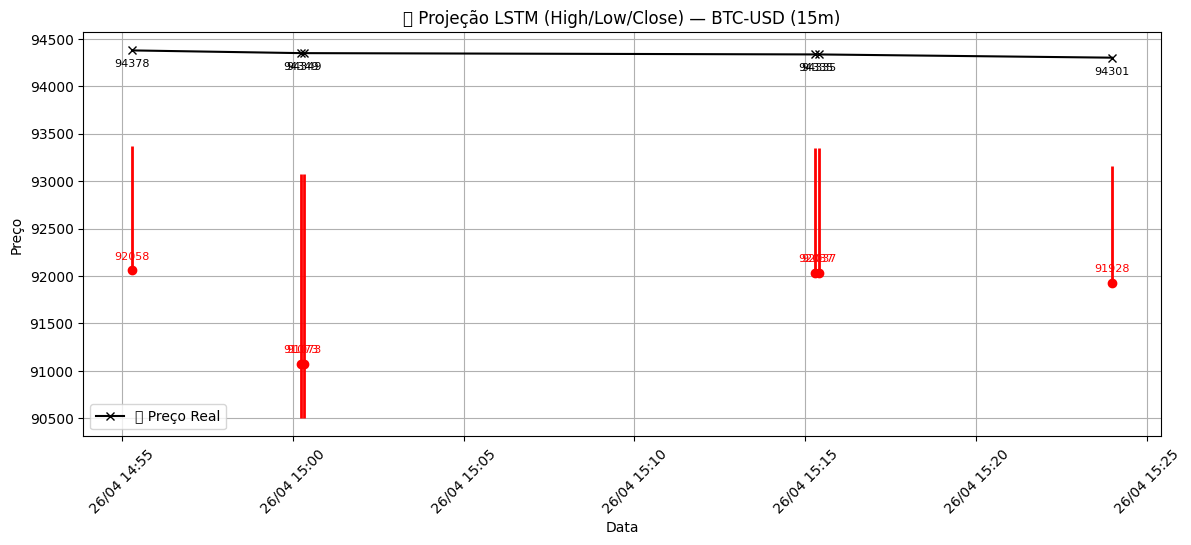

⚠️ Erro ao gerar gráficos: ['Capital Atual']


In [8]:
run_analysis(
    selected_timeframes=[
        {"interval": "15m", "period": "30d", "atr": 0.02}
    ],
    plot_timeframes=["15m"],
    alert_timeframes=["15m"],
    retrain_models=False
)


In [6]:
run_analysis(
    selected_timeframes=[
        {"interval": "1h", "period": "120d", "atr": 0.03}
    ],
    plot_timeframes=["1h"],
    alert_timeframes=["1h"],
    retrain_models=False
)


📂 Carteira virtual carregada de: /content/carteira_virtual.json

📊 Analisando BTC-USD...
📂 Modelo XGBoost carregado de: /content/models/xgb_model_BTCUSD_1h.joblib
✅ X.shape: (1260, 20, 23), y.shape: (1260, 3)
📂 Modelo LSTM encontrado em: /content/models/lstm_model_BTCUSD_1h.h5
📦 Metadados carregados de: /content/models/lstm_model_BTCUSD_1h_meta.pkl


⚠️ Ajustando Close fora da faixa. Antes: 94398.48
✅ Close ajustado para: 94918.75
🔍 Preço atual (1h): $94,313.62
🔮 Previsão LSTM: $94,918.75
📈 Variação prevista: +0.64%
🔧 ATR auto-ajustado para BTC-USD (1h): 0.01
⚠️ Targets incompletos para BTC-USD (1h) — pulando análise.

📁 Resultados salvos em: model_results_2025-04-26_18-18-43.csv
📋 Log de previsões atualizado em: /content/prediction_log.csv
💾 Carteira virtual salva em: /content/carteira_virtual.json
⚠️ Nenhum dado para BTC-USD (1h) no gráfico.
⚠️ Erro ao gerar gráficos: ['Capital Atual']


In [ ]:
clear_models("/content/models")
import os
import glob

def limpar_model_results():
    arquivos = glob.glob("/content/model_results_*.csv")
    if not arquivos:
        print("📂 Nenhum arquivo model_results_*.csv encontrado.")
        return

    for arquivo in arquivos:
        try:
            os.remove(arquivo)
            print(f"🧹 Arquivo deletado: {arquivo}")
        except Exception as e:
            print(f"❌ Erro ao deletar {arquivo}: {e}")

    print("✅ Todos os arquivos model_results_*.csv foram removidos.")

limpar_model_results()
def limpar_prediction_log(path="prediction_log.csv"):
    if not os.path.exists(path):
        print("⚠️ Arquivo de log não encontrado.")
        return

    df = pd.read_csv(path)
    df = df.dropna(subset=["Date"])
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df[df["Date"].dt.year >= 2000]
    df.to_csv(path, index=False)
    print("✅ Log limpo com sucesso. Entradas de 1970 removidas!")

limpar_prediction_log()
import os
os.remove("/content/prediction_log.csv")
import os
if os.path.exists("prediction_log.csv"):
    os.remove("prediction_log.csv")
    print("🧹 Carteira virtual resetada com sucesso.")

In [ ]:
!rm -f /content/prediction_log.csv
!rm -f /content/model_results_*.csv


In [7]:
simular_todos_trades(
    prediction_log_path="/content/prediction_log.csv",
    df_candles=None,
    timeframe="1h"
)


📊 Rodando simulação de carteira virtual com sinais do log...
📭 Nenhum trade foi simulado (ainda).
